In [39]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import spacy
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla P100-PCIE-16GB


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [42]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Neutral":
            y.values[i]=0
        else:
            y.values[i]=1
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [43]:
with open("Tech_news.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Neutral Examples : ",(X['Target']==0).sum())
print("Not Neutral Examples : ",(X['Target']==1).sum())


Number of Examples :  18187 

Number of Examples after removing duplicates:  17852 

Number of words before cleaning :  672140
Number of words after cleaning :  452084

******************

Neutral Examples :  8987
Not Neutral Examples :  8865


In [44]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])


0        mercuri system receiv contract award base new ...
1        progress second quarter revenu exce guidanc in...
2        acuiti brand declar quarterli dividend atlanta...
3         share factset soar today earn came better expect
4        stifel say inseego leader inseego corp nasdaq ...
                               ...                        
17847    appl app store polici updat affect microsoft g...
17848    investor action remind schall law firm announc...
17849    amwel propos term million ipo amwel seek rais ...
17850    jim cramer preview lennar fedex adob earn repo...
17851    rosen respect lead law firm remind alteryx inc...
Name: Article, Length: 17852, dtype: object


In [45]:
X.to_csv (r'Tech.csv', index = False, header=True)

In [46]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True


#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
Train_Data=data.TabularDataset(path = 'Tech.csv',format = 'csv',fields = fields,skip_header = True)

X_train, X_test = Train_Data.split(split_ratio=0.7, random_state = random.seed(1234))
X_train, X_val = X_train.split(split_ratio=0.8, random_state = random.seed(1234))

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  




Size of TEXT vocabulary: 11124
Size of LABEL vocabulary: 2
[('stock', 4404), ('earn', 3535), ('inc', 2762), ('compani', 2455), ('result', 2306), ('announc', 2263), ('busi', 2008), ('report', 1956), ('quarter', 1921), ('new', 1669)]


In [47]:
def find_accuracy(preds, y):
   
    temp = torch.round(preds)
    valid = (temp == y).float() 
    accur = valid.sum() / len(valid)
    return accur,temp,y

def Loss_Optimizer (model,valueLR):
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

In [48]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text, text_lengths = i.text   
        optimizer.zero_grad()
        pred = model(text, text_lengths).squeeze(1)       
        loss = criterion(pred, i.label)
        acc,dummy,dummy2 = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

In [49]:
def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text, text_lengths = i.text
            
            pred = model(text, text_lengths).squeeze(1)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list

In [50]:
def process_test(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    

In [51]:
def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')

In [52]:
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla P100-PCIE-16GB


In [53]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text, text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return F.sigmoid(out)

In [54]:
class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text,text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,hidden = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return F.sigmoid(out)

In [55]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=1024
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.3

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(11124, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
myGRU(
  (embedding): Embedding(11124, 300)
  (rnn): GRU(300, 256, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Epoch :  5  Train Loss :  0.29374089315533636   Train Acc :  0.870310252904892   Valid Loss :  0.2897144556045532  Val Acc :  0.8645804524421692
Epoch :  10  Train Loss :  0.14050611034035682   Train Acc :  0.945904940366745   Valid Loss :  0.35087411602338153  Val Acc :  0.8759390314420065
Epoch :  15  Train Loss :  0.05439054127782583   Train Acc :  0.9812868893146515   Valid Loss :  0.4703483134508133  Val Acc :  0.8756135106086731
Epoch :  20  Train Loss :  0.028968623443506657   Train Acc :  0.990106338262558   Valid Loss :  0.5536590218544006  Val Acc :  0.8733081618944804
Epoch :  25  Train Loss :  0.017186166159808634   Train Acc :  0.9949587643146515   Valid Loss :  0.62747523188591  Val Acc :  0.8831885457038879
Epoch :  30  Train Loss :  0.012994627363514154   Train Acc :  0.99521484375   Valid Loss :  0.7435933550198873  Val Acc :  0.8823000391324362
Epoch :  35  Train Loss :  0.008176041519618593   Train Acc :  0.9974609375   Valid Loss :  0.752681831518809  Val Acc :  0.8

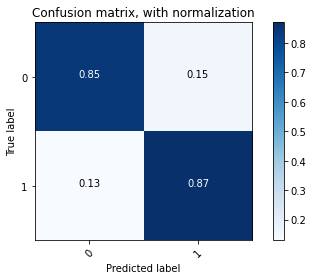

In [56]:
process_test(new_model2,40,train_it,val_it,test_it,0.001,"lstm1_loss.txt","lstm1_acc.txt","LSTM_Tech_NeutnotNeut_model.pt")

Epoch :  5  Train Loss :  0.2941023617982864   Train Acc :  0.8675129830837249   Valid Loss :  0.3233884225289027  Val Acc :  0.8523066441218058
Epoch :  10  Train Loss :  0.1459691496565938   Train Acc :  0.941278213262558   Valid Loss :  0.3860563238461812  Val Acc :  0.8615092833836874
Epoch :  15  Train Loss :  0.0764177096541971   Train Acc :  0.969696182012558   Valid Loss :  0.45721139510472614  Val Acc :  0.8689002792040507
Epoch :  20  Train Loss :  0.032051887223497035   Train Acc :  0.9883485257625579   Valid Loss :  0.6213688055674235  Val Acc :  0.8767661849657694
Epoch :  25  Train Loss :  0.02456083372235298   Train Acc :  0.9908940851688385   Valid Loss :  0.6915078361829122  Val Acc :  0.8785164952278137
Epoch :  30  Train Loss :  0.015905733034014703   Train Acc :  0.9943728268146514   Valid Loss :  0.8188457489013672  Val Acc :  0.8678356607755026
Epoch :  35  Train Loss :  0.009486511256545782   Train Acc :  0.99619140625   Valid Loss :  0.8727534413337708  Val Acc 

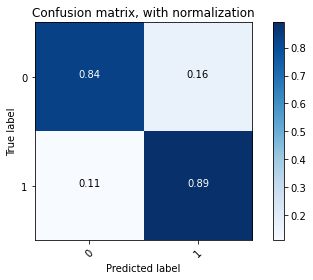

In [57]:
process_test(new_model3,40,train_it,val_it,test_it,0.001,"gru1_loss.txt","gru1_acc.txt","GRU_Tech_NeutnotNeut_model.pt")